In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf


from tensorflow import feature_column
from tensorflow.io import serialize_tensor
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [31]:
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [9]:
from google.colab import drive
drive.mount('/content/drive')

categorical_nutrition_df = pd.read_csv('/content/drive/MyDrive/categorical_nutrition.csv')
ipaq_df = pd.read_csv('/content/drive/MyDrive/ipaq.csv')
physical_activity_df = pd.read_csv('/content/drive/MyDrive/physical_activity.csv')
sovershen_one_df = pd.read_csv('/content/drive/MyDrive/sovershen_one.csv')
sovershen_two_df = pd.read_csv('/content/drive/MyDrive/sovershen_two.csv')
labels_df = pd.read_csv('/content/drive/MyDrive/labels_old.csv')
pasport_df = pd.read_csv('/content/drive/MyDrive/pasport_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
labels_df.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
pasport_df.dropna()

In [13]:
tmp = []
for row in labels_df.index:
    tmp.append(np.array(list(labels_df.loc[row, 'Артериальная гипертензия':])))
labels_one_hote = pd.DataFrame()
labels_one_hote['user_id'] = list(labels_df.loc[:, 'user_id'])
labels_one_hote['labels'] = tmp

In [14]:
labels_one_hote.loc[0, 'labels']

array([0, 0, 0, 0, 0])

In [15]:
df = pd.merge(categorical_nutrition_df.drop(columns=['Unnamed: 0']), ipaq_df.drop(columns=['Unnamed: 0']), on='user_id', how='left')
df = pd.merge(df, physical_activity_df.drop(columns=['Unnamed: 0']), on='user_id', how='left')
df = pd.merge(df, sovershen_one_df.drop(columns=['Unnamed: 0']), on='user_id', how='left')
df = pd.merge(df, sovershen_two_df.drop(columns=['Unnamed: 0']), on='user_id', how='left')
df = pd.merge(df, pasport_df.drop(columns=['Unnamed: 0']), on='user_id', how='left')
df = pd.merge(df, labels_one_hote, on='user_id', how='left')
df.drop(columns='user_id', inplace = True)

In [38]:
df.dropna(inplace = True)

In [39]:
#split to dataset
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1020 train examples
256 validation examples
320 test examples


In [17]:
# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(df, shuffle=True, batch_size=32):
    df = df.copy()
    labels = df.pop('labels')
#     print(list(labels))
    ds = tf.data.Dataset.from_tensor_slices((dict(df), list(labels)))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [40]:
batch_size = 5 # Небольшой размер пакета используется для демонстрационных целей
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [41]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of age:', feature_batch['age'])
    print('A batch of labels:', label_batch)

Every feature: ['milk', 'sour_milk', 'curd', 'cheese', 'oil', 'fruits', 'dried_fruits', 'vegetables', 'legumes', 'eggs', 'meat', 'fish', 'farinaceous_food', 'cereals', 'soups', 'juices', 'tea', 'coffee', 'soda', 'water', 'alcohol', 'sweets', 'Общая физ.активность МЕТ-мин/нед_ang', 'Активность за неделю', 'Ср.значение/день', 'Ср.активность/день_работа', 'Ср.активность/день_транспорт', 'Ср.активность/день_спорт', '%_работа', '%_транспорт', '%_спорт', 'Общее время сидения в мин', 'Прогулка MET-мин/нед', 'Умеренный MET-мин/нед', 'Энергичный MET-мин/нед', 'Общая физ.активность MET-мин/нед_КФ', 'РО-Ходьба MET-мин/нед', 'РО-Умеренные MET-мин/нед', 'РО-Энергичные MET-мин/нед', 'РО-Общая продолжительность MET-мин/нед', 'АТ-Ходьба MET-мин/нед', 'АТ-Велоспорт MET-мин/нед', 'АТ-Общий транспорт MET-мин/нед', 'ДС-Энергичные MET-мин/нед', 'ДС-Умеренные двор MET-мин/нед', 'ДС-Умеренные дом MET-мин/нед', 'ДС-Общая продолжительность MET-мин/нед', 'ЗД-Ходьба MET-мин/нед', 'ЗД-Умеренные MET-мин/нед', 'ЗД-

In [42]:
example_batch = next(iter(train_ds))[0]

In [43]:
# Служебный метод для создания столбца признаков
# и преобразования пакета данных
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [23]:
age = feature_column.numeric_column("age")
demo(age)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[57.]
 [55.]
 [66.]
 [58.]
 [36.]]


In [44]:
feature_columns = []

# численные столбцы
for header in list(df.columns.drop('labels')):
    feature_columns.append(feature_column.numeric_column(header))

In [45]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [46]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [32]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Выходные данные были обрезаны до нескольких последних строк (5000).
       [   0],
       [   0],
       [   0],
       [   0],
       [   0],
       [   0]])>, 'Общая физ.активность MET-мин/нед_КФ': <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[ 8838. ],
       [ 6294. ],
       [ 8424. ],
       [ 3052. ],
       [17365. ],
       [ 7197. ],
       [ 3763. ],
       [ 1830. ],
       [13300. ],
       [ 5190. ],
       [ 3804. ],
       [13449. ],
       [  240. ],
       [11998. ],
       [10452. ],
       [19629. ],
       [ 4029. ],
       [ 3396. ],
       [10141. ],
       [ 6031.5],
       [ 6138. ],
       [18080. ],
       [ 3306. ],
       [15978. ],
       [ 6798. ],
       [11040. ],
       [ 9639. ],
       [ 2520. ],
       [10290. ],
       [ 7155. ],
       [ 3363. ],
       [ 1692. ]])>, 'РО-Ходьба MET-мин/нед': <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[   0.],
       [2475.],
       [   0.],
       [   0.],
       [4752.],
       [5544.],
  

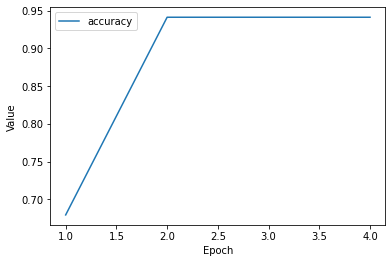

In [49]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

history =  model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

epochs = history.epoch
hist = pd.DataFrame(history.history)
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

In [51]:
loss, accuracy = model.evaluate(val_ds)
print("Accuracy", accuracy)

Выходные данные были обрезаны до нескольких последних строк (5000).
       [   0],
       [   0],
       [   0],
       [   0],
       [   0]])>, 'Общая физ.активность MET-мин/нед_КФ': <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[ 8838. ],
       [ 6294. ],
       [ 8424. ],
       [ 3052. ],
       [17365. ],
       [ 7197. ],
       [ 3763. ],
       [ 1830. ],
       [13300. ],
       [ 5190. ],
       [ 3804. ],
       [13449. ],
       [  240. ],
       [11998. ],
       [10452. ],
       [19629. ],
       [ 4029. ],
       [ 3396. ],
       [10141. ],
       [ 6031.5],
       [ 6138. ],
       [18080. ],
       [ 3306. ],
       [15978. ],
       [ 6798. ],
       [11040. ],
       [ 9639. ],
       [ 2520. ],
       [10290. ],
       [ 7155. ],
       [ 3363. ],
       [ 1692. ]])>, 'РО-Ходьба MET-мин/нед': <tf.Tensor: shape=(32, 1), dtype=float64, numpy=
array([[   0.],
       [2475.],
       [   0.],
       [   0.],
       [4752.],
       [5544.],
       [ 495.],
 

In [ ]:
model.history

In [ ]:
plot_curve(model)